# 🧪 Lab 2 — Automated LLM Fine-tuning & LoRA

This notebook automates the experiments for Lab 2:
1.  **Baseline**: Evaluate DistilGPT2 perplexity and generation.
2.  **Full Fine-tune**: Train all parameters and evaluate.
3.  **LoRA Experiments**:
    *   Standard (r=16): Evaluate performance vs Full FT.
    *   Ablation (r=1, 8, 64): Compare efficiency and forgetting.

All results (tables, generations, plots) are saved to Google Drive

In [1]:
import os
import math
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    set_seed,
    pipeline,
    BitsAndBytesConfig
)
from datasets import load_dataset, DatasetDict
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

# Set device and seed
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ==========================================
# Google Drive Setup
# ==========================================
from google.colab import drive
drive.mount('/content/drive')
RESULTS_DIR = '/content/drive/MyDrive/FINETUNE_RES'
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Google Drive mounted and folder '{RESULTS_DIR}' ensured.")

Using device: cuda
Mounted at /content/drive
Google Drive mounted and folder '/content/drive/MyDrive/FINETUNE_RES' ensured.


# 1. Data Preparation

In [2]:
def prepare_data(model_id="distilgpt2", block_size=256):
    print("Loading and processing dataset...")
    raw = load_dataset("Trelis/tiny-shakespeare")

    # Split
    split = raw["train"].train_test_split(test_size=0.02, seed=42)
    test_valid = split["test"].train_test_split(test_size=0.5, seed=42)
    dataset = DatasetDict({
        "train": split["train"],
        "validation": test_valid["train"],
        "test": test_valid["test"]
    })

    # Tokenize
    tok = AutoTokenizer.from_pretrained(model_id)
    tok.pad_token = tok.eos_token

    def tokenize_fn(ex):
        return tok(ex["Text"])

    tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["Text"])

    # Pack
    def group_texts(examples):
        concat = {k: sum(examples[k], []) for k in examples.keys()}
        total_len = (len(concat["input_ids"]) // block_size) * block_size
        result = {
            k: [t[i:i+block_size] for i in range(0, total_len, block_size)]
            for k, t in concat.items()
        }
        result["labels"] = result["input_ids"].copy()
        return result

    lm_datasets = tokenized.map(group_texts, batched=True)
    return lm_datasets, tok

# 2. Experiment Utilities

In [3]:
def compute_ppl(model, ds, tok, max_batches=50):
    model.eval()
    collator = DataCollatorForLanguageModeling(tok, mlm=False)
    loader = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=False, collate_fn=collator)
    losses = []
    for i, batch in enumerate(loader):
        if i >= max_batches: break
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            out = model(**batch)
            losses.append(out.loss.item())

    mean_loss = np.mean(losses)
    return math.exp(mean_loss)

def generate_samples(model, tok, prompts, name):
    gen_pipe = pipeline("text-generation", model=model, tokenizer=tok, device=0 if device=="cuda" else -1)
    results = []
    print(f"\n--- Generating samples for {name} ---")
    for p in prompts:
        out = gen_pipe(p, max_new_tokens=60, do_sample=True, temperature=0.9, top_p=0.92)[0]["generated_text"]
        results.append({"model": name, "prompt": p, "output": out})
    return results

# 3. Experiment Runner

In [4]:
class ExperimentRunner:
    def __init__(self, model_id="distilgpt2"):
        self.model_id = model_id
        self.lm_datasets, self.tok = prepare_data(model_id)
        self.collator = DataCollatorForLanguageModeling(self.tok, mlm=False)
        self.results_ppl = []
        self.results_gen = []

        self.prompts = [
            # Standard
            "ROMEO: I dreamt tonight that",
            "### Instruction:\nRewrite the line in modern English.\n### Input:\n'Thou art more lovely and more temperate.'\n### Response:\n",
            "SCENE PROMPTS:\nTask: 'A stormy seashore.' -> ",
            # Forgetting / Modern
            "The capital of France is",
            "Explain how a smartphone works:",
            "The internet is a global system of"
        ]

    def run_baseline(self):
        print("\n=== Running Baseline ===")
        model = AutoModelForCausalLM.from_pretrained(self.model_id).to(device)
        ppl = compute_ppl(model, self.lm_datasets["validation"], self.tok)
        print(f"Baseline PPL: {ppl:.2f}")

        self.results_ppl.append({
            "Model": "Baseline", "Rank": 0, "PPL": ppl,
            "Trainable Params": 0, "Total Params": model.num_parameters(), "Params %": 0
        })
        self.results_gen.extend(generate_samples(model, self.tok, self.prompts, "Baseline"))
        del model
        torch.cuda.empty_cache()

    def run_full_ft(self, epochs=3):
        print("\n=== Running Full Fine-tune ===")
        model = AutoModelForCausalLM.from_pretrained(self.model_id).to(device)

        args = TrainingArguments(
            output_dir="./ft-distilgpt2",
            per_device_train_batch_size=8,
            gradient_accumulation_steps=2,
            learning_rate=2e-4,
            num_train_epochs=epochs,
            logging_steps=50,
            save_strategy="no",
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        trainer = Trainer(
            model=model, args=args,
            train_dataset=self.lm_datasets["train"],
            eval_dataset=self.lm_datasets["validation"],
            data_collator=self.collator
        )
        trainer.train()

        ppl = compute_ppl(model, self.lm_datasets["validation"], self.tok)
        print(f"Full FT PPL: {ppl:.2f}")

        self.results_ppl.append({
            "Model": "Full FT", "Rank": 0, "PPL": ppl,
            "Trainable Params": model.num_parameters(), "Total Params": model.num_parameters(), "Params %": 100.0
        })
        self.results_gen.extend(generate_samples(model, self.tok, self.prompts, "Full FT"))
        del model, trainer
        torch.cuda.empty_cache()

    def run_lora(self, rank=16, epochs=2, name="LoRA"):
        print(f"\n=== Running LoRA (Rank={rank}) ===")
        model = AutoModelForCausalLM.from_pretrained(self.model_id).to(device)

        lora_cfg = LoraConfig(
            r=rank, lora_alpha=32, lora_dropout=0.05,
            target_modules=["c_attn", "q_attn", "v_attn"],
            bias="none", task_type="CAUSAL_LM"
        )
        model = get_peft_model(model, lora_cfg)

        trainable, total = model.get_nb_trainable_parameters()
        print(f"Trainable: {trainable} | %: {100*trainable/total:.4f}")

        args = TrainingArguments(
            output_dir=f"./lora-rank-{rank}",
            per_device_train_batch_size=8,
            gradient_accumulation_steps=2,
            learning_rate=1.5e-4,
            num_train_epochs=epochs,
            logging_steps=50,
            save_strategy="no",
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        trainer = Trainer(
            model=model, args=args,
            train_dataset=self.lm_datasets["train"],
            eval_dataset=self.lm_datasets["validation"],
            data_collator=self.collator
        )
        trainer.train()

        ppl = compute_ppl(model, self.lm_datasets["validation"], self.tok)
        print(f"LoRA (r={rank}) PPL: {ppl:.2f}")

        self.results_ppl.append({
            "Model": name, "Rank": rank, "PPL": ppl,
            "Trainable Params": trainable, "Total Params": total, "Params %": 100*trainable/total
        })

        # Only generate samples for the standard rank 16 run to save time, or if requested
        if rank == 16:
            self.results_gen.extend(generate_samples(model, self.tok, self.prompts, f"LoRA (r={rank})"))

        del model, trainer
        torch.cuda.empty_cache()

    def save_results(self):
        # Save PPL Table
        df_ppl = pd.DataFrame(self.results_ppl)
        csv_path = os.path.join(RESULTS_DIR, "perplexity_ablation.csv")
        df_ppl.to_csv(csv_path, index=False)
        print(f"\nSaved {csv_path}")
        print(df_ppl)

        # Save Generations
        txt_path = os.path.join(RESULTS_DIR, "generations.txt")
        with open(txt_path, "w") as f:
            for item in self.results_gen:
                f.write(f"=== Model: {item['model']} ===\n")
                f.write(f"[Prompt]: {item['prompt']}\n")
                f.write(f"[Output]: {item['output']}\n")
                f.write("-" * 60 + "\n")
        print(f"Saved {txt_path}")

        # Plot PPL Comparison
        plt.figure(figsize=(10, 6))
        # Filter for main comparison
        main_df = df_ppl[df_ppl["Model"].isin(["Baseline", "Full FT", "LoRA"])]
        if not main_df.empty:
            plt.bar(main_df["Model"] + " (r=" + main_df["Rank"].astype(str) + ")", main_df["PPL"], color=['gray', 'blue', 'orange'])
            plt.title("Perplexity Comparison: Baseline vs Full FT vs LoRA")
            plt.ylabel("Perplexity (Lower is Better)")
            plt.savefig(os.path.join(RESULTS_DIR, "ppl_comparison.png"))
            print(f"Saved {os.path.join(RESULTS_DIR, 'ppl_comparison.png')}")

        # Plot Ablation
        lora_df = df_ppl[df_ppl["Model"] == "LoRA Ablation"]
        if not lora_df.empty:
            plt.figure(figsize=(10, 6))
            plt.plot(lora_df["Rank"], lora_df["PPL"], marker='o', linestyle='-')
            plt.title("LoRA Ablation: Rank vs Perplexity")
            plt.xlabel("Rank (r)")
            plt.ylabel("Perplexity")
            plt.xscale('log')
            plt.xticks(lora_df["Rank"], lora_df["Rank"])
            plt.grid(True)
            plt.savefig(os.path.join(RESULTS_DIR, "ablation_curve.png"))
            print(f"Saved {os.path.join(RESULTS_DIR, 'ablation_curve.png')}")

# 4. Main Execution

Loading and processing dataset...


README.md:   0%|          | 0.00/497 [00:00<?, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/472 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/49 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]


=== Running Baseline ===


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
Device set to use cuda:0


Baseline PPL: 68.46

--- Generating samples for Baseline ---

=== Running Full Fine-tune ===


Step,Training Loss
50,4.027200
100,3.644100
150,3.456900
200,3.358400
250,3.307200


Device set to use cuda:0


Full FT PPL: 25.81

--- Generating samples for Full FT ---

=== Running LoRA (Rank=16) ===


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Trainable: 294912 | %: 0.3587


Step,Training Loss
50,4.351200
100,4.274000
150,4.215400


Device set to use cuda:0


LoRA (r=16) PPL: 49.04

--- Generating samples for LoRA (r=16) ---

=== Starting Ablation Study ===

=== Running LoRA (Rank=1) ===


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Trainable: 18432 | %: 0.0225


Step,Training Loss
50,4.353600


LoRA (r=1) PPL: 53.23

=== Running LoRA (Rank=8) ===


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Trainable: 147456 | %: 0.1797


Step,Training Loss
50,4.354900


LoRA (r=8) PPL: 53.57

=== Running LoRA (Rank=64) ===


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Trainable: 1179648 | %: 1.4197


Step,Training Loss
50,4.357200


LoRA (r=64) PPL: 53.53

Saved /content/drive/MyDrive/FINETUNE_RES/perplexity_ablation.csv
           Model  Rank        PPL  Trainable Params  Total Params    Params %
0       Baseline     0  68.463922                 0      81912576    0.000000
1        Full FT     0  25.806270          81912576      81912576  100.000000
2           LoRA    16  49.035558            294912      82207488    0.358741
3  LoRA Ablation     1  53.228673             18432      81931008    0.022497
4  LoRA Ablation     8  53.573079            147456      82060032    0.179693
5  LoRA Ablation    64  53.527786           1179648      83092224    1.419685
Saved /content/drive/MyDrive/FINETUNE_RES/generations.txt
Saved /content/drive/MyDrive/FINETUNE_RES/ppl_comparison.png
Saved /content/drive/MyDrive/FINETUNE_RES/ablation_curve.png

✅ All experiments completed. Results saved to: /content/drive/MyDrive/FINETUNE_RES


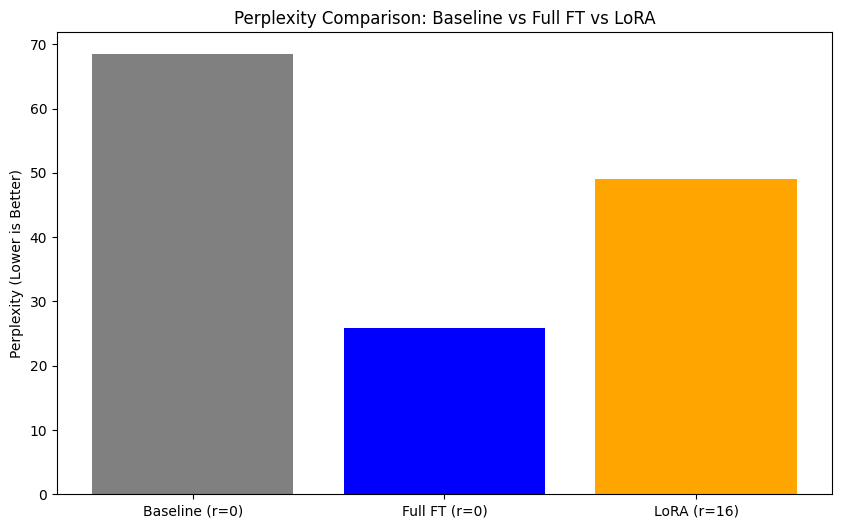

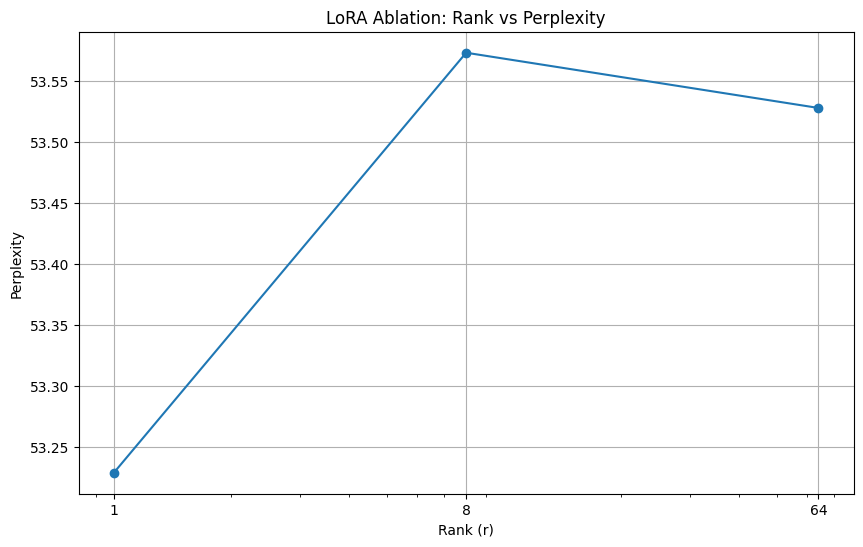

In [5]:
runner = ExperimentRunner()

# 1. Baseline
runner.run_baseline()

# 2. Full Fine-tune (3 epochs)
runner.run_full_ft(epochs=3)

# 3. LoRA Standard (r=16, 2 epochs)
runner.run_lora(rank=16, epochs=2, name="LoRA")

# 4. LoRA Ablation (r=1, 8, 64 - 1 epoch for speed)
print("\n=== Starting Ablation Study ===")
for r in [1, 8, 64]:
    runner.run_lora(rank=r, epochs=1, name="LoRA Ablation")

# 5. Save all results
runner.save_results()

print(f"\n✅ All experiments completed. Results saved to: {RESULTS_DIR}")